## 学习率的设置
训练神经网络的时候，需要设置学习率(learning rate)来控制参数的更新速度。学习率决定了参数每次更新的幅度，如果学习率设置过大，则可能导致参数的极值附近震荡。如果学习率设置过小，虽然能保证参数收敛到极值，但是这会大大降低参数收敛的速度。<br/>
为了解决这个问题，TensorFlow提供了`指数衰减法`来设置学习率。`tf.train.exponential_decay`函数实现了指数衰减学习率，通过使用这个函数，可以先使用较大的学习率来比较快速的得到一个比较优的解，然后随着迭代次数的增加逐渐减小学习率，使得模型训练在后期比较稳定。<br/>
tf.train.exponential_decay函数会指数级减小学习率，实现了以下功能：<br/>

In [ ]:
# learning_rate:初始学习率
# decay_rate:衰减系数
# decay_step:衰减速度
decayed_learning_rate=learning_rate * decay_rate^(global_step/decay_step)

<div style="width:70%;height:70%;">
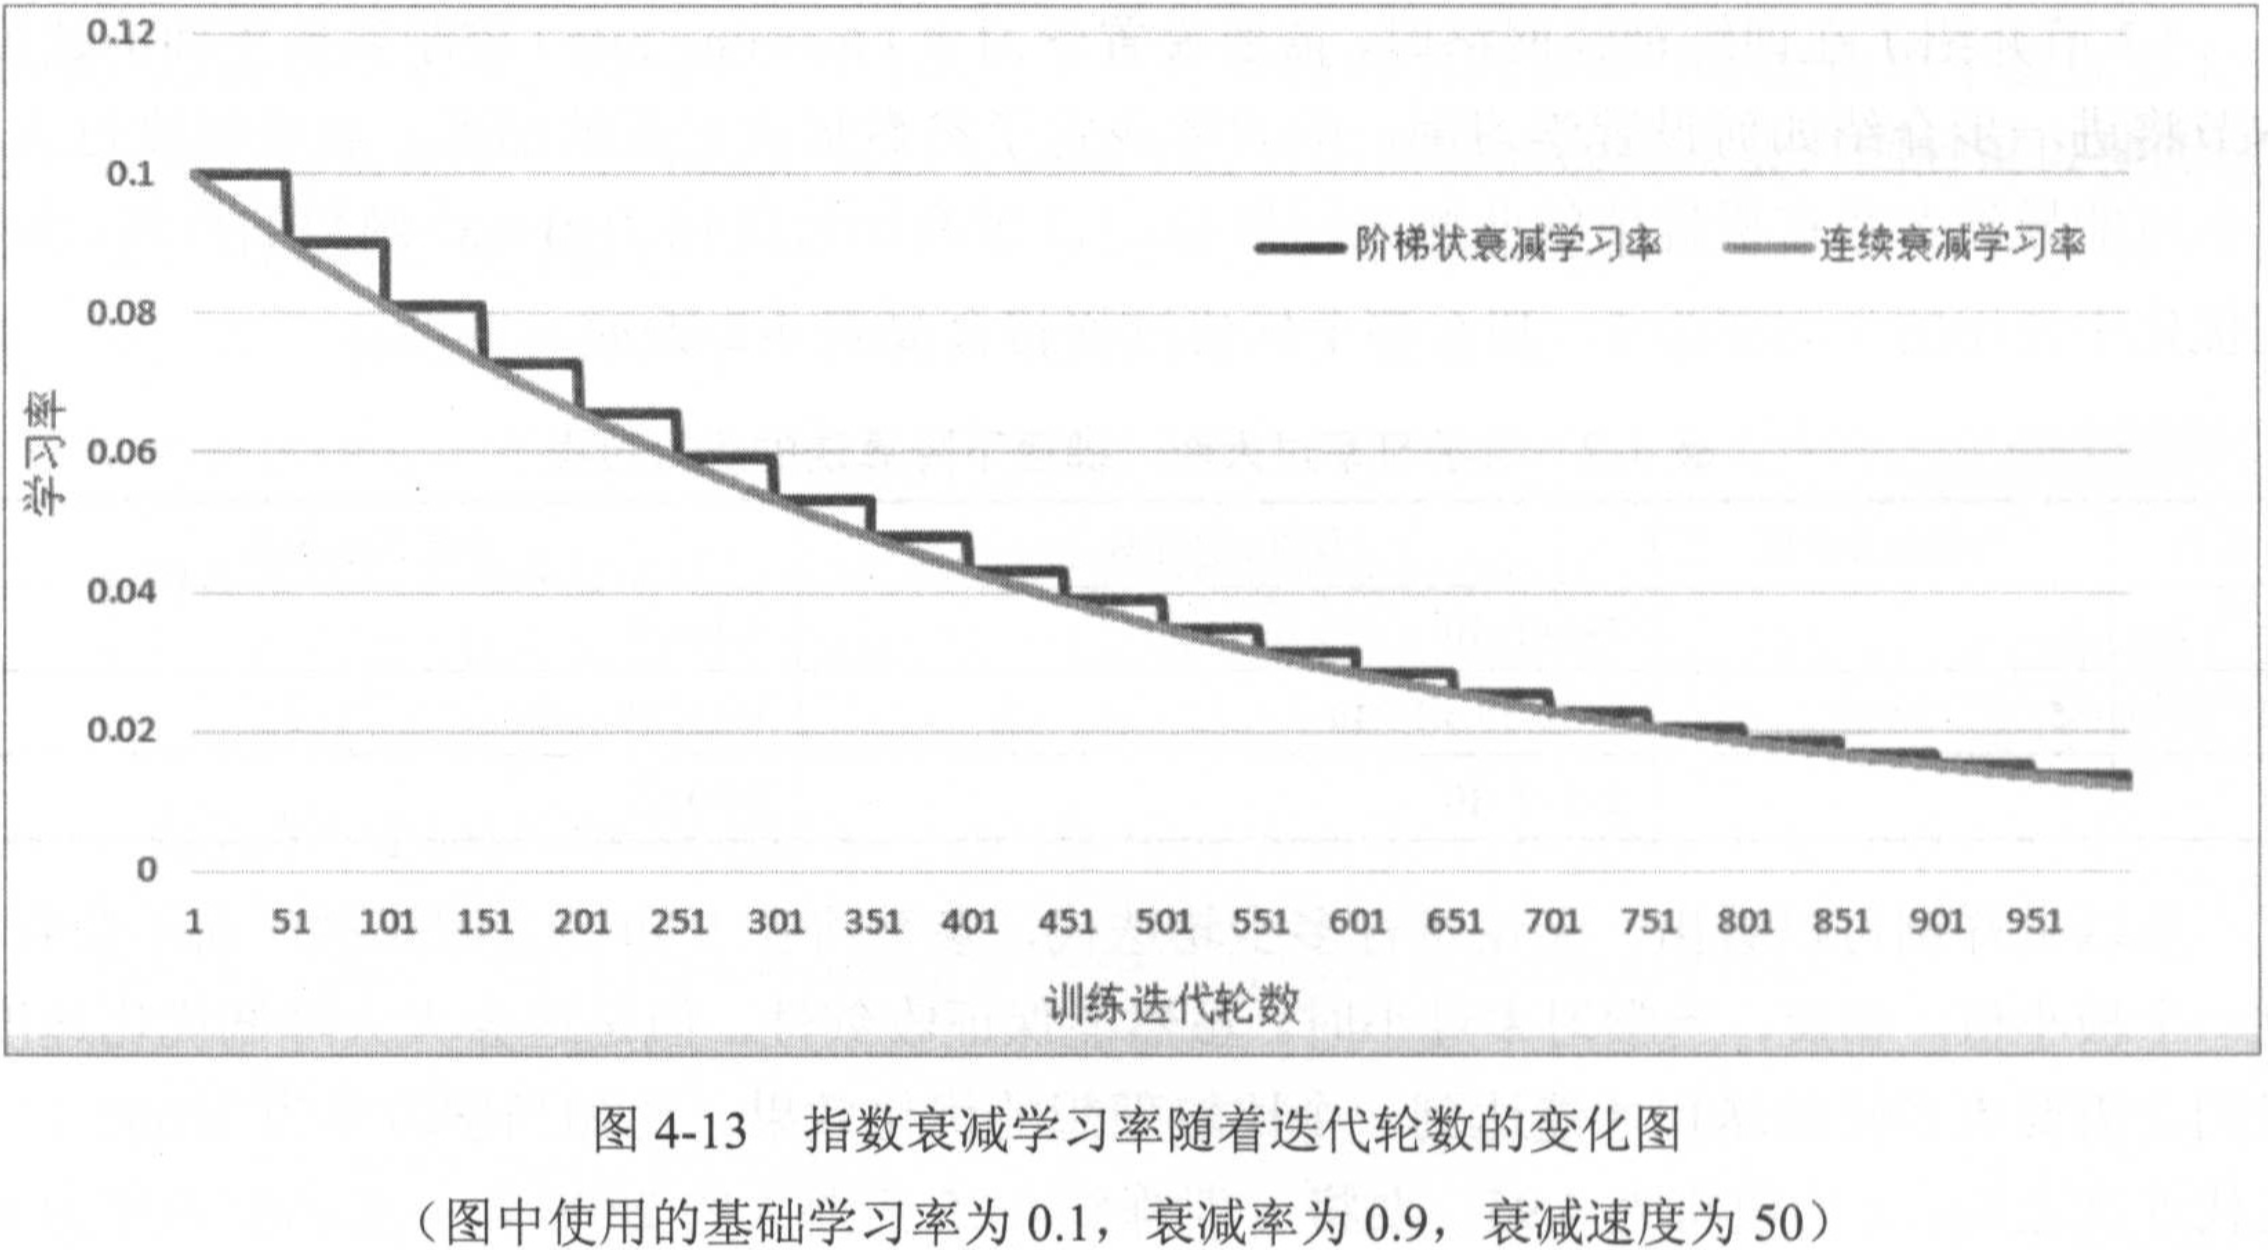
</div>
tf.train.exponential_decay函数可以通过设置`staircase参数`来选择不同的衰减方式。当`staircase=False`时，随之迭代次数的增加，学习率`平滑`下降。当`staircase=True`时，global_step/decay_step会转为整数，这使得学习率呈现`阶梯`状，而decay_step通常代表完整使用一次训练数据所需要的迭代次数。这个迭代次数为总训练数除以batch中训练样本数。global_step经常在滑动平均，学习速率变化的时候需要用到，系统会自动更新这个参数的值，从1开始。学习速率第一次训练开始变化，global_steps每次自动加1。<br/>
tf.train.exponential_decay示例代码：

In [ ]:
import tensorflow as tf

global_step = tf.Variable(0)
# 通过exponential_decay函数生成学习率
# 0.1：初始学习率
# 每100轮后学习率乘以0.96
learning_rate = tf.train.exponential_decay(
    0.1, global_step, 100, 0.96, staircase=True)
train_step = tf.train.GradientDescentOptimizer(learning_rate)
               .minimize(loss_function, global_step=global_step)

## 过拟合问题
过拟合问题是模型在训练数据集上具有很高的准确性，但是在测试集中准确率很低。这是由于模型过于复杂导致的过拟合问题。为了避免过拟合问题，常见的处理方法是使用`正则化(regularization)`。正则化的思想是在损失函数中加入刻画模型复杂度的指标，即$J(\theta) + \lambda R(w)$，其中$R(w)$刻画的是模型的复杂程度，而$\lambda$表示模型复杂损失在总损失中的比例。注意：这里的$\theta$表示一个神经网络中的所有参数，包括权重$w$和偏置项$b$。不过一般来说，模型的复杂程度只有权重$w$来决定。<br/>
函数$R(w)$一般有两种，一种是$L1$正则化：
$$R(w) = \|w\|_{1} = \sum_{i}w_i$$
另一种是$L2$正则化：
$$R(w) = \|w\|_2^2 = \sum_{i}|w_i^2|$$
无论使用哪种正则化方式，目的都是为了通过限制模型的复杂度，使得模型不能任意拟合训练数据中的随机噪声。<br/>
$L1$正则化和$L2$正则化的区别：
1. L1正则化会使参数变得更加稀疏，L2正则化不会。所谓参数变得更稀疏是指会使更多的参数变成0，从而达到类似特征选取的功能。L2不会让参数变得稀疏是因为当参数很小时，这个参数的平方基本可以忽略不计，于是模型不会进一步将这个参数调整为0。
2. L1正则化计算式不可导，L2正则化计算式可导。因为优化时需要计算损失函数的偏导数，对含有L2正则化损失函数的优化更加简洁。优化带有L1正则式的损失函数更加复杂，而且优化方法很多。在实践中，也可以L1正则式和L2正则式一起使用：

$$R(w) = \sum_{i}\alpha |w_i| + (1 - \alpha)w_i^2$$
在TensorFlow中，TensorFlow提供了`tf.contrib.layers.l2_regularizer`函数，用于计算一个给定参数的$L2$正则化项的值；`tf.contrib.layers.l1_regularizer`函数，用于计算一个给定参数的$L1$正则化项的值。
函数的使用示例：

In [1]:
import tensorflow as tf

weights = tf.constant([[1.0, -2.0], [-3.0, 4.0]])
with tf.Session() as sess:
    print(sess.run(tf.contrib.layers.l1_regularizer(.5)(weights)))
    print(sess.run(tf.contrib.layers.l2_regularizer(.5)(weights)))

5.0
7.5


简单的带L2正则化的损失函数定义

In [ ]:
import tensorflow as tf

weights = tf.Variable(tf.random_normal([2,1], stddev=1, seed=1))
y = tf.matmul(x, weights)

loss = tf.reduce_mean(y_ - y) + 
        tf.contrib.layers.l2_regularizer(.5)(weights)

虽然上述的方式可以很简单的计算带正则式的损失函数，但是当神经网络的参数增多时，会导致损失函数的定义过长，这样可读性差而且容易出错。另外，当网络比较复杂时，定义神经网络结构的部分和计算损失函数的部分可能不在同一函数，这样通过变量的方式计算损失函数就不是很方便。为了解决这个问题，TensorFlow提供了集合(collection)。<br/>
通过集合(collection)计算一个5层神经网络带L2正则化的损失函数的计算方法：

In [ ]:
import tensorflow as tf
# 获取神经网络的权重，并将损失函数的l2正则化项加入collection
def get_weight(shape, lambda_var):
    # 随机初始化权重
    weight = tf.Variable(tf.random_normal(shape), dtype=tf.float32)
    # 将权重的l2正则化项加入名为losses的集合中。
    tf.add_to_collection(
        'losses', tf.contrib.layers.l1_l2_regularizer(lambda_var)(weight))
    return weight

x = tf.placeholder(tf.float32, shape=(None, 2), name='x-input')
y_ = tf.placeholder(tf.float32, shape=(None, 1), name='y-output')
batch_size = 8
# 定义神经网络每层的节点数
layer_dimension = [2, 10, 10, 10, 1]
# 定义神经网络的总层数
n_layers = len(layer_dimension)
# 初始输入层为x
cur_layer = x
# 当前层的节点个数
in_dimension = layer_dimension[0]

# 初始化5层全连接的神经网络结构
for i in range(1, n_layers):
    # layer_dimension[i]为下一层的节点个数
    out_dimension = layer_dimension[i]
    # 获取当前层中权重的变量
    weight = get_weight((in_dimension, out_dimension), 0.001)
    bias = tf.Variable(tf.constant(0.1, shape=[out_dimension]))
    # 使用Relu激活函数
    cur_layer = tf.nn.relu(tf.matmul(cur_layer, weight) + bias)
    # 下一层的节点个数
    in_dimension = layer_dimension[i]

# 训练数据上的损失函数
mse_loss = tf.reduce_mean(tf.square(y_ - y))
# 将均方误差损失函数加入损失集合
tf.add_to_collection('losses', mse_loss)
# 将集合中的元素加起来得到最终的损失函数
loss = tf.add_n(tf.get_collection('losses'))

## 滑动平均模型
### 滑动平均法
滑动平均法是一种简单的平滑预测技术，基本思想是：根据时间序列资料、逐项推移，依次计算包含一定项数的序时平均值，以反映长期趋势的一种方法。滑动平均法可以分为：简单滑动平均和加权滑动平均。<br/>
#### 简单滑动平均法
简单滑动平均法的各元素的权重都相等。简单滑动平均的计算公式如下：
$$
F_t = \frac{A_{t-1} + A_{t-2} + \cdots + A_{t-n}}{n}
$$
其中：

- $F_t$：对下一期的预测值；<br/>
- $n$：移动平均的时期个数；<br/>
- $A_{t-1}$：前期实际值；<br/>
#### 加权滑动平均法
加权移动平均给固定跨越期限内的每个变量值以不同的权重。加权滑动平均法的计算公式如下：<br/>
$$
F_t = w_1A_{t-1} + w_2A_{t-2} + \cdots + w_nA_{t-n}
$$
在运用加权平均法时，权重的选择是一个应该注意的问题。经验法和权重法是选择权重的最简单的方法。<br/>
#### 滑动平均法优缺点
使用滑动平均法进行预测能平滑掉需求的突然波动对预测结果的影响。但滑动平均法运用也存在如下问题：<br/>
1. 加大滑动平均法的n值会使平滑波动效果更好，但会使预测值对时局实际变动更不敏感；<br/>
2. 滑动平均法并不能总是很好的地反映出趋势。由于平均值，预测值总是停留在过去的水平上而无法预计会导致将来更高或更低的波动；<br/>
3. 滑动平均法要有大量过去数据的记录。<br/>
### 滑动平均模型
滑动平均模型可以使得模型在测试数据上更加健壮，在使用随机梯度下降算法训练神经网路时，通过滑动平均模型可以在很多的应用中一定程度上提高最终模型在测试数据上的表示。<br/>
在TensorFlow中提供了`tf.train.ExponentialMovingAverage`来实现滑动平均模型。<br/>
> tf.train.ExponentialMovingAverage(decay, num_updates=None, zero_debias=False, name="ExponentialMovingAverage")<br/>

在初始化ExponentialMovingAverage时，需要提供一个衰减率(decay)。这个衰减率用于控制模型更新速度，ExponentialMovingAverage对每个变量会维护一个影子变量(shadow variable)，这个影子变量的初始值就是相应变量的初始值，而每次运行变量更新时，影子变量的值会被更新为：
$$shadow\_variable=decay\times shadow\_variable+(1-decay)\times variable$$
其中shadow_variable为影子变量，variable为待更新的变量，decay为衰减率。decay决定了模型更新的速度，decay越大模型越趋于稳定。在实际应用中，decay一般会设成非常接近于1的数，比如0.999或0.9999。<br/>
为了使模型在训练前期可以更新得更快，ExponentialMovingAverage还提供了`num_updates`参数来动态设置decay的大小。如果在ExponentialMovingAverage初始化时提供了num_updates参数，那么每次使用的衰减率将是：
$$\min \{decay, \frac{1+num\_updates}{10+num\_updates}\}$$

In [2]:
import tensorflow as tf
# 定义一个滑动变量用于平均滑动，变量初始值为0，变量类型必须实数
v1 = tf.Variable(0, dtype=tf.float32)
# 定义迭代轮数的变量，动态控制衰减率，并设置为不可训练
step = tf.Variable(10, trainable=False)
# 定义一个滑动平均类，初始化衰减率为0.99
ema = tf.train.ExponentialMovingAverage(0.99, step)
# 定义一个滑动平均更新的列表
main_ema_op = ema.apply([v1])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(main_ema_op)
    print(sess.run([v1, ema.average(v1)]))
    sess.run(tf.assign(v1, 4))
    sess.run(main_ema_op)
    print(sess.run([v1, ema.average(v1)]))

[0.0, 0.0]
[4.0, 1.8]
